# *FORECASTING* CON REDES LSTM - PARTE 1: PREPARACIÓN DE LOS DATOS

## Contenido

1. [Introducción]
2. [El set de datos]
3. [El problema a resolver]
4. [Lectura del set de datos]
5. [Procesamiento inicial del dataset]
6. [Análisis exploratorio]
7. [Pre-procesamiento]
8. [Conclusión]

## 1. Lectura del set de datos

In [110]:
#from google.colab import drive
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

# Montar Google Drive
#drive.mount('/gdrive')

# Leer set de datos
ruta = './'
datos = pd.read_csv(ruta+'VOLTAREN AEROSOL_2017_2023.csv', delimiter=';')
#datos = pd.read_csv(ruta+'Ventas_SENSODYNEBLANQ_2016_2024.csv', delimiter=';')
#datos = pd.read_csv(ruta+'Ventas_XARELTO_2016_2024.csv', delimiter=';')

datos.head()



,Fecha,Codigo,POS,id_item,Descripcion_larga,cantidad,latitud,longitud
0,2/3/2018 13:18,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D
1,18/3/2018 10:34,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D
2,11/5/2018 10:59,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D
3,20/5/2018 16:51,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D
4,24/3/2018 13:54,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D


In [111]:
idItem = 13480

In [112]:
datos.rename(columns={'cantidad': 'cantidad_frac'}, inplace=True)
datos.head()

,Fecha,Codigo,POS,id_item,Descripcion_larga,cantidad_frac,latitud,longitud
0,2/3/2018 13:18,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D
1,18/3/2018 10:34,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D
2,11/5/2018 10:59,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D
3,20/5/2018 16:51,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D
4,24/3/2018 13:54,CG008,CA GYE MAPASINGUE,13480,VOLTAREN AEROSOL 1%x85MLx1,1,#N/D,#N/D


## 2. Procesamiento inicial del dataset

In [113]:
# Suponiendo que df es tu DataFrame original y quieres seleccionar solo ciertas columnas
columnas_especificas = ['Fecha', 'id_item', 'cantidad_frac']
datos = datos[columnas_especificas]
datos = datos[datos['id_item'] == idItem]


In [114]:
def validar_y_actualizar(fila):
    if  fila["cantidad_unid"] >= 1:
        if (fila['id_item'] == 13887): #JERINGA MEGA INSUL 1MLx29Gx1/2x100
          fila["cantidad_frac"] += 100 * int(fila["cantidad_unid"])
          #datos = datos = datos.rename(columns={'cantidad_unid': 'cantidad_frac'})
          #fila["cantidad_unid"] = 0
        elif fila['id_item'] in {90765, 79680, 27112, 1669, 101609, 13480}: #x'unidad  
          fila["cantidad_frac"] += int(fila["cantidad_unid"])

        elif(fila['id_item'] == 54122): #XARELTO COM-RECx10MGx10
          fila["cantidad_frac"] += 10 * int(fila["cantidad_unid"])
        
        elif(fila['id_item'] == 88275): #MICARDIX
           fila['cantidad_frac'] += 28 * int(fila["cantidad_unid"])  

    return fila


# Aplicar la función a cada fila
datos = datos.apply(validar_y_actualizar, axis=1)
datos = datos.drop(columns = ["cantidad_unid"])

KeyError: 'cantidad_unid'

### 2.1 Manipulación de fechas

In [115]:
# verificar que el tipo de dato es object 'O'
datos["Fecha"].dtype

dtype('O')

In [116]:
# Pasar la columna de Fecha al formato datetime
datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%d/%m/%Y %H:%M')
# Establecer la hora y el minuto a 0
datos['Fecha'] = datos['Fecha'].apply(lambda dt: dt.replace(hour=0, minute=0, second=0))
datos = datos.groupby(['Fecha', 'id_item'], as_index= False).sum()
# Ordenemos el dataset de forma ascendente según "fecha"
datos.sort_index(inplace=False)
datos.set_index('Fecha', inplace= True)
df = datos


In [117]:
df.head()


,id_item,cantidad_frac
Fecha,,
2017-01-01,13480,19
2017-01-02,13480,25
2017-01-03,13480,32
2017-01-04,13480,28
2017-01-05,13480,33


## 3. Pre-procesamiento

**Se tiene 6 variables**
- *Fecha*: Fecha de compra del producto
- *codigo*: codigo de la farmacia donde se compro el producto
- *POS*: nombre de la farmacia
- *id_item*: codigo del producto
- *Descripcion_larga*: nombre del producto
- *cantidad_uni*: cantidad de producto comprada


**Tendremos dos tipos de variables al momento de implementar los modelos LSTM:**
- Variable a predecir: la variable a pronosticar (salida del modelo LSTM). En este caso es *cantidad_unid*

- Variables predictoras (o covariables): las variables de entrada al modelo LSTM a partir de las cuales se realizará la predicción.
  - Puede incluir la variable a predecir (*cantidad_unid*)
  - Puede incluir la variable tiempo (columna *Fecha*)


---



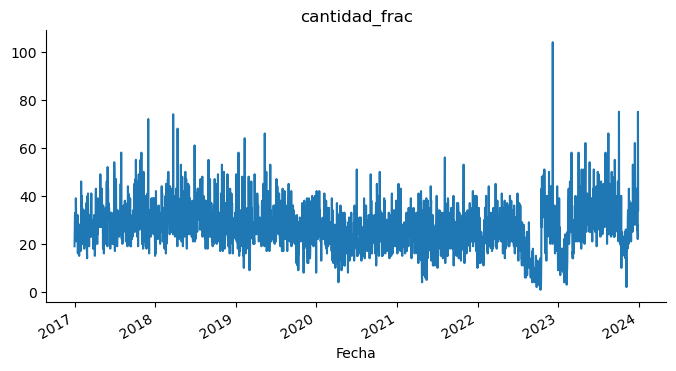

In [118]:
df['cantidad_frac'].plot(kind='line', figsize=(8, 4), title='cantidad_frac')
plt.gca().spines[['top', 'right']].set_visible(False)

**Observaciones:**
Al parecer hay varios outliers, en específico el que está a mediados del año 2022. Otro punto a considerar es que no se encuentran registros del año 2021 por motivos de pandemia es un año que se presta a valores atipicos.


---



In [119]:
# verficar datos faltantes
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()

    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna id_item: 0
	Columna cantidad_frac: 0


garantizar que la periodicidad de las muestras es exactamente de 1 día:

In [120]:
# Convertir el índice a fecha y hora si aún no lo está
df.index = pd.to_datetime(df.index)

# Calcular diferencias (en días) entre cada par de datos consecutivos
df_time_diffs = df.index.to_series().diff().dt.days

# Contar las ocurrencias de cada diferencia
print(df_time_diffs.value_counts())

Fecha
1.0    2542
2.0       6
Name: count, dtype: int64



Por lo tanto vemos que:

- hay 2178 pares de registro con una diferencia de 1 día.
- hay 4 pares de registro con una diferencia de 2 días.
- hay 1 par de registros con una diferencia de 368 días. (la fecha de pandemia)

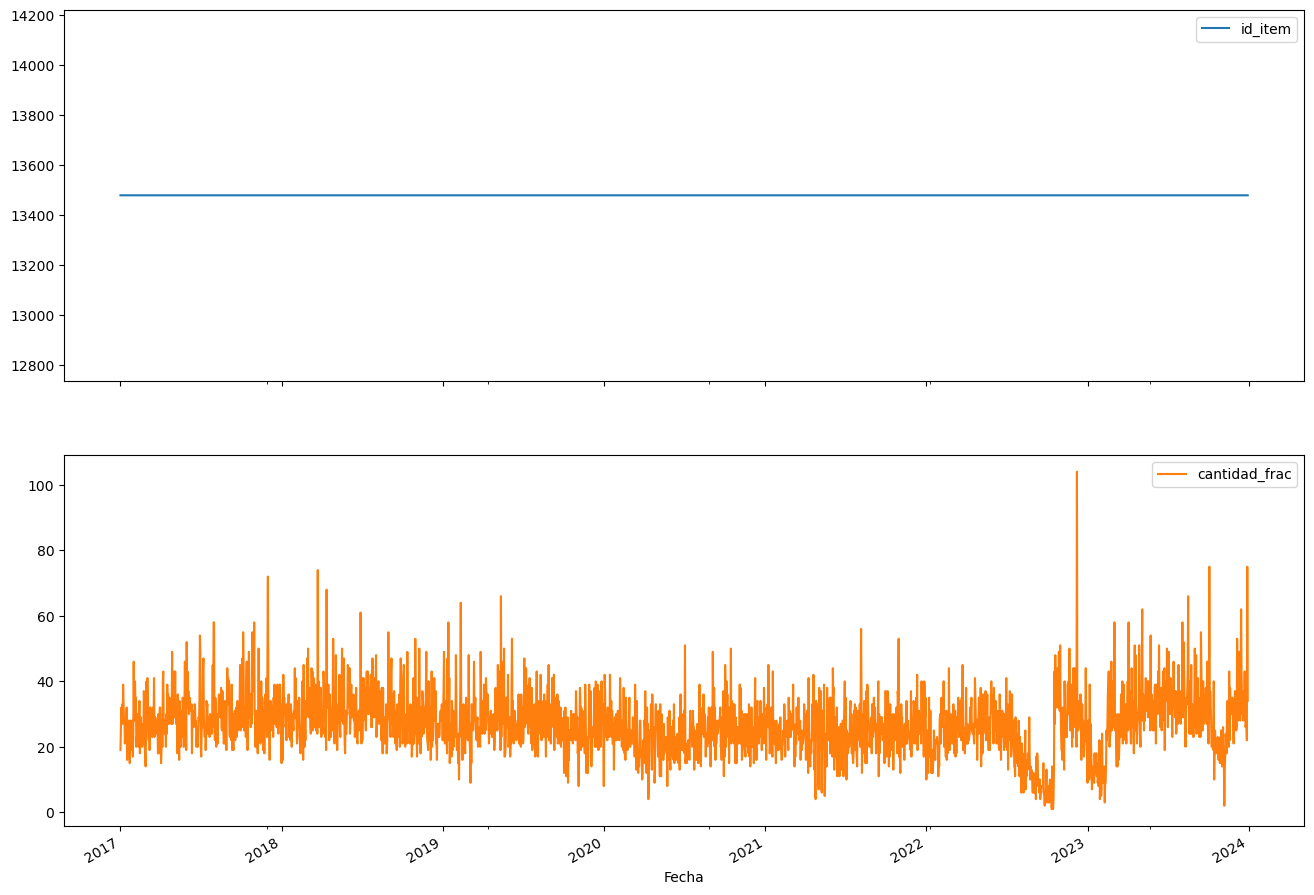

In [121]:
# Dibujemos nuestras variables
cols = df.columns

# N = 24*30*12 # Dibujar 1 año continuo
N = df.shape[0]
plots = df[cols][0:N]
plots.index = df.index[0:N]
_ = plots.plot(subplots=True, figsize=(16,12))

No hay datos faltantes
Pero debemos mejorar la perioricidad del dataset

### 3.1. Ajuste de la periodicidad del dataset


In [122]:
# Reinterpolar el dataset con una periodicidad de 1 día
#df2 = df.asfreq(freq='D', method='bfill')
#df2 = df.asfreq(freq='D', method='ffill')
df2 = df.asfreq(freq='D', fill_value=0)


# Y verificar que la totalidad del dataset tiene esta periodicidad
df_time_diffs = df2.index.to_series().diff().dt.days
print(df_time_diffs.value_counts())

Fecha
1.0    2554
Name: count, dtype: int64


In [123]:
# Función para eliminar outliers y reemplazarlos por el valor promedio
# def eliminar_outliers(df, columnas):
#     for columna in columnas:
#         Q1 = df[columna].quantile(0.25)
#         Q3 = df[columna].quantile(0.75)
#         IQR = Q3 - Q1
#         limite_inferior = Q1 - 1.5 * IQR
#         limite_superior = Q3 + 1.5 * IQR

#         # Calcular el promedio sin outliers
#         promedio_sin_outliers = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)][columna].mean()

#         # Reemplazar los outliers por el promedio
#         df[columna] = df[columna].apply(lambda x: promedio_sin_outliers if (x < limite_inferior or x > limite_superior) else x)

#     return df

# #Seleccionar las columnas que deseas procesar
# columnas_a_procesar = ['cantidad_frac']  # Ajusta según tus necesidades

# # Aplicar la función
# df2 = eliminar_outliers(df2, columnas_a_procesar)




In [124]:
# Verificar que el dataset resultante no contiene NaNs:
print('Cantidad de NaNs:')
for column in df:
    nans = df2[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna id_item: 0
	Columna cantidad_frac: 0


In [125]:
# Y finalmente verificar las columnas originales y modificadas
# para constatar que los valores promedio no cambian

for column in df:
  # Verificar si la columna actual es de tipo flotante
  if pd.api.types.is_numeric_dtype(df2[column]):
    # Calcular y imprimir promedios solo para columnas flotantes
    print(f'Promedios original/modificado: {df2[column].mean():.2f}/{df2[column].mean():.2f}')


Promedios original/modificado: 13448.34/13448.34
Promedios original/modificado: 27.05/27.05


In [126]:
df = df2

### En este punto ya contamos con un dataset íntegro (no contiene datos faltantes ni *outliers* y tiene una periodicidad de 1 día).
---



### 3.2. Partición del set de entrenamiento y prueba

1. Partición en train/val/test (80%, 10%, 10%)
2. Generación del dataset supervisado: entrada y salida del modelo
3. Escalamiento

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Recordemos además que:
- El set de entrenamiento (*train*) se usará para encontrar los parámetros del modelo
- El set de validación (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperparámetros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación

In [127]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

#tr_size = 0.8 80% para el entrenamiento
#vl_size = 0.1 10% para la validación
#ts_size = 0.1 10% para el test


def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df['cantidad_frac'])

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (2044,)
Tamaño set de validación: (255,)
Tamaño set de prueba: (256,)


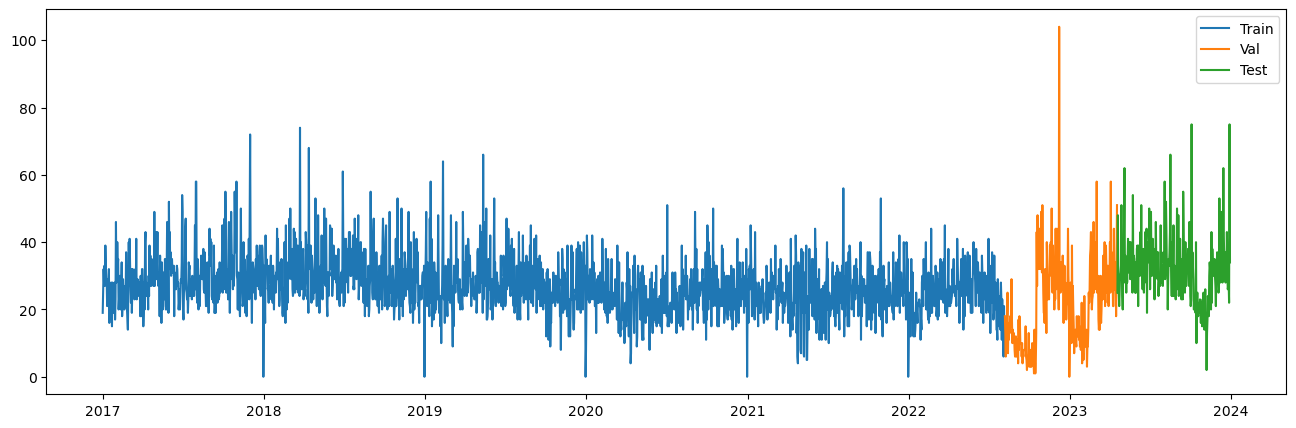

In [128]:
# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
plt.legend();

### 3.3. Generación del dataset supervisado (entrada y salida del modelo)

Debemos ajustar nuestro set de datos de acuerdo a lo especificado en la [documentación de las Redes LSTM en TensorFlow/Keras](https://www.tensorflow.)

![](https://drive.google.com/file/d/1ij9pIsJrWVYbwKrZZHY8KtNTlUs1o6AJ/view?usp=sharing)


se tiene 3 dimensiones para la entrada y salida. Como se puede ver en la figura se tiene n cantidad registros(BATCHES) que representan bloques, en la cual cada registro tiene 24 horas como periodo.

Output_lenght: numero de horas que queremos predecir a futuro.

Features(caracteristica) en este caso solo es 1 dado que nuestro modelo es univariado

Output_lenght como es un modelo unistep solo es 1


![image-3.png](attachment:image-3.png)

In [129]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [130]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 5    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (2015, 24, 1), y_tr: (2015, 5, 1)
Set de validación - x_vl: (226, 24, 1), y_vl: (226, 5, 1)
Set de prueba - x_ts: (227, 24, 1), y_ts: (227, 5, 1)


### 3.4. Escalamiento
Es requerido para garantizar que todas las características se encuentran en el mismo rango de valores, lo que facilita el entrenamiento del modelo y las predicciones:

#### Detección de valores extremos usando el método de la desviación estándar
La distribución Gaussiana se caracteriza por la media (𝜇) y la desviación estándar (𝜎). Conociendo los parámetros de esta distribución podemos establecer una serie de umbrales dentro de los cuales se encontrarán distriubidos nuestros datos, así:

En el rango 𝜇±𝜎 tendremos el 68% de los datos
En el rango 𝜇±2𝜎 tendremos el 95% de los datos
En el rango 𝜇±3𝜎 tendremos el 99.7% de los datos


In [131]:
# import plotly.express as px
# #Primero vamos a identificar el comportamiento de los outliers mediante una campana gaussiana para observar como está la distribución
# fig = px.histogram(df, x='cantidad_frac', nbins=100)
# fig.show()

### STANDARSCALER

In [132]:
from sklearn.preprocessing import StandardScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]


    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [StandardScaler() for i in range(NFEATS)]  # Remove feature_range
    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
    # (en este caso 24x13)
    print('NFEATS: '+ str(NFEATS))
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0].reshape(-1,1))
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }



    return data_scaled, scalers[0]

### ROBUSTSCALER

In [133]:
from sklearn.preprocessing import RobustScaler
import numpy as np

def escalar_dataset(data_input):
    '''Escala el dataset usando RobustScaler.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [RobustScaler() for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)


    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
    # (en este caso 30x1)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(data_input['x_tr'][:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(data_input['x_vl'][:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(data_input['x_ts'][:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(data_input['y_tr'][:,:,0].reshape(-1,1))
    y_vl_s[:,:,0] = scalers[-1].transform(data_input['y_vl'][:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(data_input['y_ts'][:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]


### MIN MAX SCALER

In [134]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]


    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
    # (en este caso 24x13)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [135]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento: 0/0/2
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-1.0/-0.9459459459459459

Min y_tr/y_vl/y_ts sin escalamiento: 0/0/2
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-1.0/-0.9459459459459459

Max x_tr/x_vl/x_ts sin escalamiento: 74/104/75
Max x_tr/x_vl/x_ts con escalamiento: 1.0/1.810810810810811/1.0270270270270272

Max y_tr/y_vl/y_ts sin escalamiento: 74/104/75
Max y_tr/y_vl/y_ts con escalamiento: 1.0/1.810810810810811/1.0270270270270272


In [136]:
import pickle

# Escalamiento del dataset
data_s, scaler = escalar_dataset(data_in)

# Guardar el scaler en un archivo .pkl
with open(f'scaler_{idItem}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## 4. Creación y entrenamieto del Modelo

### 4.1 DROPOUT

In [137]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout

import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 129 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 30 (días) x 1 (feature)
DROPOUT_RATE = 0.5  # Tasa de dropout (ajústala según tus necesidades)


modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dropout(DROPOUT_RATE))  # Agregar capa Dropout
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Pérdida: se usará el MAE (mean absolute error) para el entrenamiento
# pues permite medir el error absoluto promedio
def mean_absolute_error(y_true, y_pred):
    mae = tf.math.reduce_mean(tf.abs(y_pred - y_true))
    return mae


# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error
)

# Mostrar la estructura del modelo
modelo.summary()


c:\Users\jeanf\miniconda3\envs\streamlit\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 129)            │        67,596 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 129)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,246 (266.59 KB)

 Trainable params: 68,246 (266.59 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 50 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/50
8/8 - 1s - 181ms/step - loss: 0.3568 - val_loss: 0.5429
Epoch 2/50
8/8 - 0s - 29ms/step - loss: 0.3482 - val_loss: 0.5319
Epoch 3/50
8/8 - 0s - 31ms/step - loss: 0.3409 - val_loss: 0.5217
Epoch 4/50
8/8 - 0s - 34ms/step - loss: 0.3341 - val_loss: 0.5117
Epoch 5/50
8/8 - 0s - 34ms/step - loss: 0.3285 - val_loss: 0.5016
Epoch 6/50
8/8 - 0s - 29ms/step - loss: 0.3216 - val_loss: 0.4912
Epoch 7/50
8/8 - 0s - 36ms/step - loss: 0.3146 - val_loss: 0.4804
Epoch 8/50
8/8 - 0s - 32ms/step - loss: 0.3074 - val_loss: 0.4691
Epoch 9/50
8/8 - 0s - 32ms/step - loss: 0.2999 - val_loss: 0.4571
Epoch 10/50
8/8 - 0s - 29ms/step - loss: 0.2930 - val_loss: 0.4446
Epoch 11/50
8/8 - 0s - 29ms/step - loss: 0.2838 - val_loss: 0.4314
Epoch 12/50
8/8 - 0s - 41ms/step - loss: 0.2754 - val_loss: 0.4175
Epoch 13/50
8/8 - 0s - 41ms/step - loss: 0.2660 - val_loss: 0.4031
Epoch 14/50
8/8 - 0s - 34ms/step - loss: 0.2586 - val_loss: 0.3887
Epoch 15/50
8/8 - 0s - 30ms/step - loss: 0.2501 - val_loss: 0.3749
Epo

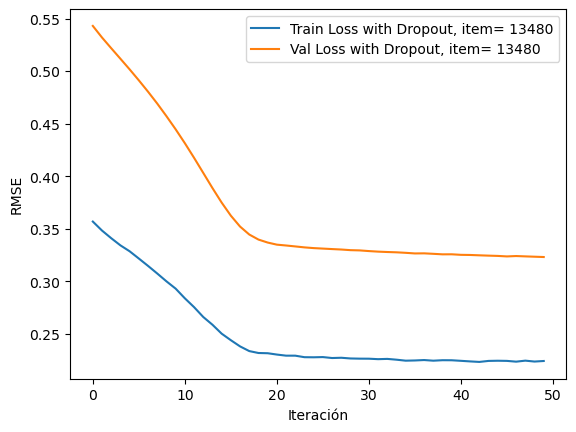

In [139]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label=f'Train Loss with Dropout, item= {idItem}')
plt.plot(historia.history['val_loss'],label=f'Val Loss with Dropout, item= {idItem}')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### 4.2 SIN DROPOUT

In [140]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop


import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 229 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 30 (días) x 1 (feature)



modelo_sin_dropout = Sequential()
modelo_sin_dropout.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

modelo_sin_dropout.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Pérdida: se usará el MAE (mean absolute error) para el entrenamiento
# pues permite medir el error absoluto promedio
def mean_absolute_error(y_true, y_pred):
    mae = tf.math.reduce_mean(tf.abs(y_pred - y_true))
    return mae



# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo_sin_dropout.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error
)

# Mostrar la estructura del modelo
modelo_sin_dropout.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 229)            │       211,596 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,746 (831.04 KB)

 Trainable params: 212,746 (831.04 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 50 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia_sin_dropout = modelo_sin_dropout.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/50
8/8 - 2s - 194ms/step - loss: 0.3377 - val_loss: 0.5068
Epoch 2/50
8/8 - 0s - 61ms/step - loss: 0.3258 - val_loss: 0.4905
Epoch 3/50
8/8 - 1s - 64ms/step - loss: 0.3155 - val_loss: 0.4744
Epoch 4/50
8/8 - 0s - 56ms/step - loss: 0.3048 - val_loss: 0.4573
Epoch 5/50
8/8 - 0s - 60ms/step - loss: 0.2933 - val_loss: 0.4385
Epoch 6/50
8/8 - 0s - 56ms/step - loss: 0.2805 - val_loss: 0.4174
Epoch 7/50
8/8 - 0s - 57ms/step - loss: 0.2662 - val_loss: 0.3940
Epoch 8/50
8/8 - 0s - 60ms/step - loss: 0.2505 - val_loss: 0.3691
Epoch 9/50
8/8 - 0s - 54ms/step - loss: 0.2350 - val_loss: 0.3461
Epoch 10/50
8/8 - 0s - 57ms/step - loss: 0.2230 - val_loss: 0.3305
Epoch 11/50
8/8 - 0s - 53ms/step - loss: 0.2173 - val_loss: 0.3243
Epoch 12/50
8/8 - 0s - 54ms/step - loss: 0.2161 - val_loss: 0.3229
Epoch 13/50
8/8 - 0s - 58ms/step - loss: 0.2159 - val_loss: 0.3226
Epoch 14/50
8/8 - 0s - 53ms/step - loss: 0.2159 - val_loss: 0.3225
Epoch 15/50
8/8 - 0s - 54ms/step - loss: 0.2159 - val_loss: 0.3225
Epo

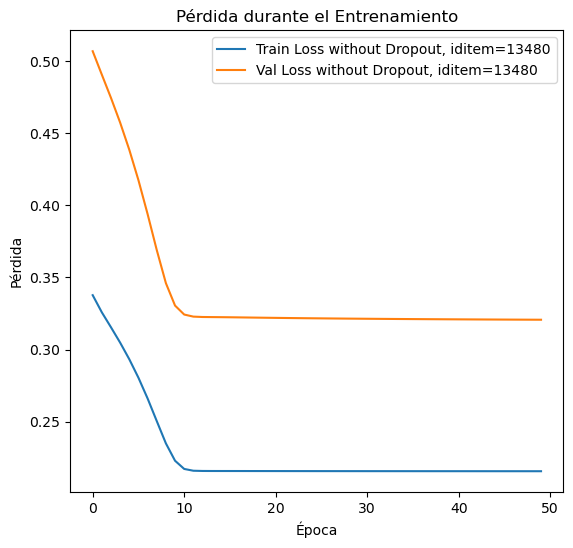

In [142]:
import matplotlib.pyplot as plt

# Graficar el error de entrenamiento y validación para el modelo con Dropout
plt.figure(figsize=(14, 6))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(historia_sin_dropout.history['loss'], label=f'Train Loss without Dropout, iditem={idItem}')
plt.plot(historia_sin_dropout.history['val_loss'], label=f'Val Loss without Dropout, iditem={idItem}')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


## GUARDAR MODELO

In [143]:
# Guardar el modelo entrenado
modelo.save(f'modelo_{idItem}.keras')
#modelo.save(f'modelo_{idItem}.keras')

# CARGAR MODELO 1

In [144]:
# def preparar_datos_para_prediccion(df, id_item, input_length, output_length, scaler, modelo):
#     """
#     Predice los valores de los próximos días a partir del último registro en el DataFrame.

#     Args:
#     df (pd.DataFrame): DataFrame que contiene las columnas 'fecha', 'id_item', 'cantidad_frac'.
#     id_item (int/str): El ID del item para el cual se quieren hacer predicciones.
#     input_length (int): El número de registros que el modelo necesita como entrada.
#     output_length (int): El número de días a predecir.
#     scaler: El objeto MinMaxScaler que se usó para escalar los datos durante el entrenamiento.
#     modelo: El modelo LSTM cargado para hacer predicciones.

#     Returns:
#     np.array: Predicciones desescaladas para los próximos días.
#     """
#     # Suponiendo que df es tu DataFrame original y quieres seleccionar solo ciertas columnas
#     columnas_especificas = ['Fecha', 'id_item','cantidad_unid', 'cantidad_frac']
#     df = df[columnas_especificas]


#     # Filtrar el DataFrame para el id_item deseado
#     df_item = df[df['id_item'] == id_item].copy()

#     # Ordenar por fecha y tomar los últimos 'input_length' registros
#     df_item = df_item.sort_values(by='Fecha').tail(input_length)

#     # Asegurarse de que los datos estén en el formato correcto (n_samples, input_length, n_features)
#     datos = df_item['cantidad_frac'].values.reshape(-1, 1)

#     # Crear un array con las características que espera el scaler (relleno con ceros)
#     datos_expandidos = np.zeros((input_length, scaler.n_features_in_))
#     datos_expandidos[:, 0] = datos[:, 0]  # Copiar los valores en la primera columna

#     # Escalar los datos
#     datos_escalados = scaler.transform(datos_expandidos)

#     # Seleccionar solo la primera columna escalada para la predicción
#     datos_escalados = datos_escalados[:, 0].reshape(1, input_length, 1)

#     predicciones = []

#     # Iterativamente predecir los próximos días
#     for _ in range(output_length):
#         # Hacer la predicción
#         prediccion = modelo.predict(datos_escalados)

#         # Crear un array expandido para desescalado
#         prediccion_expandidas = np.zeros((prediccion.shape[0], scaler.n_features_in_))
#         prediccion_expandidas[:, 0] = prediccion[:, 0]

#         # Invertir el escalado de la predicción
#         prediccion_invertida = scaler.inverse_transform(prediccion_expandidas)

#         # Agregar la primera columna a las predicciones finales
#         predicciones.append(prediccion_invertida[0, 0])

#         # Añadir la nueva predicción a los datos para predecir el siguiente día
#         nueva_entrada = prediccion[0, 0].reshape(1, 1, 1)
#         datos_escalados = np.append(datos_escalados[:, 1:, :], nueva_entrada, axis=1)

#     return np.array(predicciones)


In [145]:

# # Ejemplo de uso:
# id_item = 13887  # Reemplaza con tu id_item específico
# input_length = 24  # Este es el valor que usaste para entrenar tu modelo
# output_length = 5  # Los 5 días que quieres predecir

# # Realizar las predicciones
# predicciones_5_dias = preparar_datos_para_prediccion(df3, id_item, input_length, output_length, scaler_cargado, modelo_cargado)

# print("Predicciones para los próximos 5 días:", predicciones_5_dias)

# CARGAR MODELO 2

In [146]:
from tensorflow.keras.models import load_model
from datetime import timedelta


# Cargar el modelo guardado en formato Keras
modelo_cargado = load_model('modelo_88275.keras', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# Ahora puedes usar el modelo cargado para hacer predicciones
# Por ejemplo, utilizando el mismo código que tenías antes para predecir futuros valores
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x, verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

# Obtener la última fecha del conjunto de datos
ultima_fecha = df.index[-1]

# Generar un rango de fechas futuras
num_predicciones = 4  # Número de días a predecir
fechas_futuras = [ultima_fecha + timedelta(days=i) for i in range(1, num_predicciones + 1)]

# Preparar el último segmento del conjunto de datos de entrada desde el conjunto de test
ultimo_segmento = ts[-INPUT_LENGTH:].values
ultimo_segmento = ultimo_segmento.reshape((1, INPUT_LENGTH, 1))

# Obtener las predicciones futuras usando el modelo cargado
predicciones_futuras = []
segmento_actual = ultimo_segmento

for _ in range(num_predicciones):
    prediccion = predecir(segmento_actual, modelo_cargado, scaler)
    predicciones_futuras.append(prediccion[0])

    # Actualizar el segmento actual
    nuevo_valor = np.array(prediccion[0]).reshape(1, 1, 1)
    segmento_actual = np.append(segmento_actual[:, 1:, :], nuevo_valor, axis=1)


# Crear un DataFrame con las predicciones futuras y sus fechas
resultados_futuros = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})


resultados_futuros

,Fecha,Predicción
0,2023-12-31,21.170570
1,2024-01-01,22.922865
2,2024-01-02,22.640924
3,2024-01-03,22.682037


In [147]:
# from tensorflow.keras.models import load_model
# from datetime import timedelta
# import pandas as pd
# import numpy as np

# def predecir_con_modelo(df, modelo, scaler, input_length, num_predicciones, id_item):
#     """
#     Transforma un DataFrame y genera predicciones futuras utilizando un modelo LSTM cargado.

#     Args:
#     df (pd.DataFrame): DataFrame que contiene las columnas 'fecha', 'id_item', 'cantidad_frac'.
#     modelo: Modelo LSTM cargado desde un archivo .keras.
#     scaler: Objeto MinMaxScaler utilizado para escalar los datos.
#     input_length (int): Número de registros que el modelo necesita como entrada.
#     num_predicciones (int): Número de días a predecir.
#     id_item (int/str): El ID del item para el cual se quieren hacer predicciones.

#     Returns:
#     pd.DataFrame: DataFrame con las fechas futuras y sus correspondientes predicciones.
#     """

#     # Filtrar el DataFrame para el id_item deseado
#     df_item = df[df['id_item'] == id_item].copy()

#     # Obtener la última fecha del conjunto de datos
#     ultima_fecha = df_item['Fecha'].max()

#     # Asegúrate de que 'ultima_fecha' sea un objeto datetime
#     if isinstance(ultima_fecha, str):
#         # Si es una cadena, conviértela a datetime
#         # (Asumiendo que el formato de fecha es 'YYYY-MM-DD')
#         ultima_fecha = pd.to_datetime(ultima_fecha)

#     # Generar un rango de fechas futuras
#     fechas_futuras = [ultima_fecha + timedelta(days=i) for i in range(1, num_predicciones + 1)]


#     # Preparar el último segmento del conjunto de datos de entrada
#     ultimo_segmento = df_item['cantidad_frac'].values[-input_length:]
#     ultimo_segmento = ultimo_segmento.reshape((1, input_length, 1))

#     # Escalar el último segmento
#     ultimo_segmento_escalado = np.zeros((input_length, scaler.n_features_in_))
#     ultimo_segmento_escalado[:, 0] = ultimo_segmento[:, 0, 0]
#     ultimo_segmento_escalado = scaler.transform(ultimo_segmento_escalado)
#     segmento_actual = ultimo_segmento_escalado[:, 0].reshape(1, input_length, 1)

#     # Obtener las predicciones futuras usando el modelo cargado
#     predicciones_futuras = []

#     for _ in range(num_predicciones):
#         prediccion = modelo.predict(segmento_actual, verbose=0)

#         # Desescalar la predicción
#         prediccion_expandidas = np.zeros((prediccion.shape[0], scaler.n_features_in_))
#         prediccion_expandidas[:, 0] = prediccion[:, 0]
#         prediccion_invertida = scaler.inverse_transform(prediccion_expandidas)

#         # Agregar la primera columna a las predicciones finales
#         predicciones_futuras.append(prediccion_invertida[0, 0])

#         # Actualizar el segmento actual
#         nuevo_valor = prediccion[0, 0].reshape(1, 1, 1)
#         segmento_actual = np.append(segmento_actual[:, 1:, :], nuevo_valor, axis=1)

#     # Crear un DataFrame con las predicciones futuras y sus fechas
#     resultados_futuros = pd.DataFrame({
#         'Fecha': fechas_futuras,
#         'Predicción': predicciones_futuras
#     })

#     return resultados_futuros

# # Ejemplo de uso:
# #df = pd.read_csv('tu_archivo.csv')  # Reemplaza con tu archivo de datos
# input_length = 24  # Este es el valor que usaste para entrenar tu modelo
# num_predicciones = 4  # Número de días a predecir
# id_item =13887  # Reemplaza con tu id_item específico

# # Cargar el modelo guardado en formato Keras
# modelo_cargado = load_model('modelo_ventas_insulina.keras', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# # Generar las predicciones usando la función
# resultados_futuros = predecir_con_modelo(df3, modelo_cargado, scaler, input_length, num_predicciones, id_item)

print(resultados_futuros)


       Fecha  Predicción
0 2023-12-31   21.170570
1 2024-01-01   22.922865
2 2024-01-02   22.640924
3 2024-01-03   22.682037


In [148]:
# print("Número de dimensiones:", resultados_futuros.ndim)
# print("Forma del arreglo:", resultados_futuros.shape)
# print("Número total de elementos:", resultados_futuros.size)

# DESEMPEÑO DEL MODELO

In [149]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños con Dropout:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños con Dropout:
  RMSE train:	 0.212
  RMSE val:	 0.316
  RMSE test:	 0.249


Los desempeños son comparables lo cual quiere decir que el modelo generaliza bastante bien.

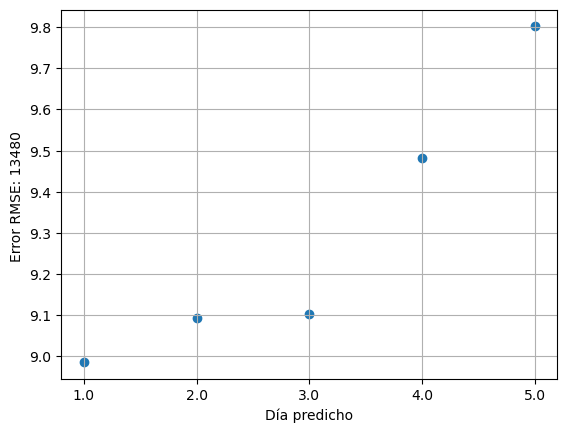

In [150]:
# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Realizar la transformación inversa de las predicciones para llevar sus
# valores a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # 284x5
proms = np.mean(diff_cuad, axis=0) # 1x5
rmse = np.sqrt(proms) # 1x5

# Graficar rmse para cada timestep
t = np.linspace(1,5,5) # Changed to match the length of rmse

fig, ax = plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Día predicho')
ax.set_ylabel(f'Error RMSE: {idItem} ')
plt.xticks(ticks=t, labels=t)
plt.grid();

In [151]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [152]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

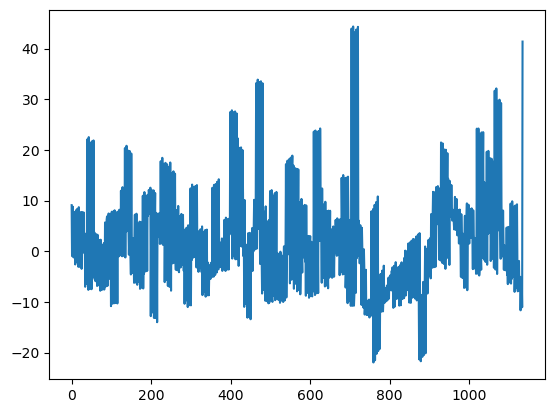

In [153]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [154]:
 from datetime import timedelta

# Obtener la última fecha del conjunto de datos
ultima_fecha = df.index[-1]

# Generar un rango de fechas futuras
num_predicciones = 5  # Número de días a predecir
fechas_futuras = [ultima_fecha + timedelta(days=i) for i in range(1, num_predicciones + 1)]

# Preparar el último segmento del conjunto de datos de entrada desde el conjunto de test
ultimo_segmento = ts[-INPUT_LENGTH:].values
ultimo_segmento = ultimo_segmento.reshape((1, INPUT_LENGTH, 1))

# Obtener las predicciones futuras
predicciones_futuras = []
segmento_actual = ultimo_segmento.copy()  # Create a copy to avoid modifying the original

for _ in range(num_predicciones):
    prediccion = predecir(segmento_actual, modelo, scaler)
    predicciones_futuras.append(prediccion[0])

    # Actualizar el segmento actual - Instead of appending and slicing,
    # shift the values and insert the new prediction at the end
    segmento_actual = np.roll(segmento_actual, -1, axis=1)
    segmento_actual[0,-1,0] = prediccion[0]

# Crear un DataFrame con las predicciones futuras y sus fechas
resultados_futuros = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})

resultados_futuros.set_index('Fecha', inplace=True)


In [155]:
print(resultados_futuros)

            Predicción
Fecha                 
2023-12-31   79.327217
2024-01-01   79.638573
2024-01-02   79.324669
2024-01-03   79.128204
2024-01-04   78.941093
